In [1]:
%matplotlib inline
from tvb.simulator.lab import *
import matplotlib.pyplot as plt
import numpy as np

Having multiple stimuli with different time courses for different nodes currently requires an extra class, see usage below

In [2]:
from tvb.basic.neotraits.api import NArray, Attr

class MultiStimuliRegion(patterns.StimuliRegion):
    connectivity = Attr(connectivity.Connectivity, required=False)
    temporal = Attr(field_type=equations.TemporalApplicableEquation, required=False)
    weight = NArray(required=False)
    
    def __init__(self, *stimuli):
        super(MultiStimuliRegion, self).__init__()
        self.stimuli = stimuli
    def configure_space(self, *args, **kwds):
        [stim.configure_space(*args, **kwds) for stim in self.stimuli]
    def configure_time(self, *args, **kwds):
        [stim.configure_time(*args, **kwds) for stim in self.stimuli]
    def __call__(self, *args, **kwds):
        return np.array([stim(*args, **kwds) for stim in self.stimuli]).sum(axis=0)

Now we can make several pulse trains with different temporal configurations and node weights, and combine them with above class.

WARNING  File 'hemispheres' not found in ZIP.


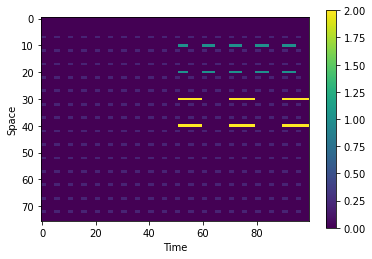

In [3]:
conn = connectivity.Connectivity.from_file()
nnode = conn.weights.shape[0]

def make_train(node_idx, node_weights, **params):
    weighting = np.zeros(nnode)
    weighting[node_idx] = node_weights
    eqn_t = equations.PulseTrain()
    eqn_t.parameters.update(params)
    stimulus = patterns.StimuliRegion(
        temporal=eqn_t,
        connectivity=conn,
        weight=weighting)
    return stimulus

train1 = make_train([10, 20], 1.0, onset=1.5e3, T=100.0, tau=50.0)
train2 = make_train([30, 40], 2.0, onset=1.5e3, T=200.0, tau=100.0)
train3 = make_train(np.r_[7:74:5], 0.2, onset=5e2, T=50.0, tau=20.0)
stimulus = MultiStimuliRegion(train1, train2, train3)
stimulus.configure_space()
time = np.r_[1e3:2e3:10.0]
stimulus.configure_time(time)
pattern = stimulus()
plt.imshow(pattern, interpolation='none')
plt.xlabel('Time')
plt.ylabel('Space')
plt.colorbar()

Here we just visualize the output of `stimulus`, but it could also be passed to a simulator object for simulation.